<a href="https://colab.research.google.com/github/osiris-contreras/Anal-tica-en-Recursos-Humanos/blob/main/modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import os
path= '/content/drive/MyDrive/codigos/Anal-tica-en-Recursos-Humanos'
os.chdir(path)
sys.path.append(path+'/')

## Visual Studio

In [1]:
import os
import sys

ruta =os.getcwd()
sys.path.append(ruta)

# Modelo

In [13]:
import warnings
warnings.filterwarnings("ignore")



# Importar librerias necesarias
import sqlite3 as sql
import pandas as pd
import a_funciones as fn ### importar modulo de  funciones
from a_funciones import * ### importar toddas llas funciones del archivo

from sklearn import linear_model ## para regresión lineal
from sklearn import tree ###para ajustar arboles de decisión
from sklearn.ensemble import RandomForestRegressor ##Ensamble con bagging
from sklearn.ensemble import GradientBoostingRegressor ###Ensamble boosting
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt ### gráficos
from sklearn.model_selection import RandomizedSearchCV
import joblib  ### para guardar modelos
from sklearn.preprocessing import StandardScaler ## escalar variables
#import openpyxl

In [3]:
#### conectarse a base de datos preprocesada

con=sql.connect('bases de datos RRHH/datos.db')
cur=con.cursor()

In [4]:
### ver todas las bases de datos ###

cur.execute("select name from sqlite_master where type='table';")
cur.fetchall()


[('retiros',),
 ('general',),
 ('employee_survey',),
 ('manager_survey',),
 ('completo',)]

In [5]:
pd.read_sql(""" select * from completo""", con=con)

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,...,InfoDate,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Attrition,retirementDate,retirementType,resignationReason
0,51,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,Healthcare Representative,...,2015-12-31,3.0,4.0,2.0,3,3,0,0,NoRetirement,NoRetirement
1,31,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,Research Scientist,...,2015-12-31,3.0,2.0,4.0,2,4,1,2016-10-15,Resignation,Others
2,32,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,Sales Executive,...,2015-12-31,2.0,2.0,1.0,3,3,0,0,NoRetirement,NoRetirement
3,38,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,Human Resources,...,2015-12-31,4.0,4.0,3.0,2,3,0,0,NoRetirement,NoRetirement
4,32,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,Sales Executive,...,2015-12-31,4.0,1.0,3.0,3,3,0,0,NoRetirement,NoRetirement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8815,42,Travel_Rarely,Research & Development,5,4,Medical,4406,Female,1,Research Scientist,...,2016-12-31,4.0,1.0,3.0,3,3,0,0,NoRetirement,NoRetirement
8816,29,Travel_Rarely,Research & Development,2,4,Medical,4407,Male,1,Laboratory Technician,...,2016-12-31,4.0,4.0,3.0,2,3,0,0,NoRetirement,NoRetirement
8817,25,Travel_Rarely,Research & Development,25,2,Life Sciences,4408,Male,2,Sales Executive,...,2016-12-31,1.0,3.0,3.0,3,4,0,0,NoRetirement,NoRetirement
8818,42,Travel_Rarely,Sales,18,2,Medical,4409,Male,1,Laboratory Technician,...,2016-12-31,4.0,1.0,3.0,2,3,0,0,NoRetirement,NoRetirement


In [6]:
#crear dataframe para el modelado(2015)
df_m = pd.read_sql("""select * from completo
where InfoDate='2015-12-31'
""",con=con)

In [7]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   BusinessTravel           4410 non-null   object 
 2   Department               4410 non-null   object 
 3   DistanceFromHome         4410 non-null   int64  
 4   Education                4410 non-null   int64  
 5   EducationField           4410 non-null   object 
 6   EmployeeID               4410 non-null   object 
 7   Gender                   4410 non-null   object 
 8   JobLevel                 4410 non-null   int64  
 9   JobRole                  4410 non-null   object 
 10  MaritalStatus            4410 non-null   object 
 11  MonthlyIncome            4410 non-null   int64  
 12  NumCompaniesWorked       4410 non-null   float64
 13  PercentSalaryHike        4410 non-null   int64  
 14  StockOptionLevel        

In [8]:
#Eliminación de variables InfoDate y retirementDate, ya que no son relevantes dentro del dataframe (informacion 2015-retiros 2016)
df_m=df_m.drop(columns=['InfoDate','retirementDate'])
df_m.columns

Index(['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EducationField', 'EmployeeID', 'Gender', 'JobLevel', 'JobRole',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'Attrition',
       'retirementType', 'resignationReason'],
      dtype='object')

In [9]:
#Cambiar variables float a integer
columnas_float=df_m.select_dtypes(include=['float']).columns

df_m[columnas_float]=df_m[columnas_float].astype(int)
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      4410 non-null   int64 
 1   BusinessTravel           4410 non-null   object
 2   Department               4410 non-null   object
 3   DistanceFromHome         4410 non-null   int64 
 4   Education                4410 non-null   int64 
 5   EducationField           4410 non-null   object
 6   EmployeeID               4410 non-null   object
 7   Gender                   4410 non-null   object
 8   JobLevel                 4410 non-null   int64 
 9   JobRole                  4410 non-null   object
 10  MaritalStatus            4410 non-null   object
 11  MonthlyIncome            4410 non-null   int64 
 12  NumCompaniesWorked       4410 non-null   int32 
 13  PercentSalaryHike        4410 non-null   int64 
 14  StockOptionLevel         4410 non-null  

In [10]:
#Conversion a Dummyes
list_dummies=['BusinessTravel', 'Department','EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'retirementType',
       'resignationReason']


df_dummies=pd.get_dummies(df_m,columns=list_dummies)



In [11]:
df_dummies.head()

,Age,DistanceFromHome,Education,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,...,MaritalStatus_Married,MaritalStatus_Single,retirementType_Fired,retirementType_NoRetirement,retirementType_Resignation,resignationReason_Fired,resignationReason_NoRetirement,resignationReason_Others,resignationReason_Salary,resignationReason_Stress
0,51,6,2,1,1,131160,1,11,0,1,...,True,False,False,True,False,False,True,False,False,False
1,31,10,1,2,1,41890,0,23,1,6,...,False,True,False,False,True,False,False,True,False,False
2,32,17,4,3,4,193280,1,15,3,5,...,True,False,False,True,False,False,True,False,False,False
3,38,2,5,4,3,83210,3,11,3,13,...,True,False,False,True,False,False,True,False,False,False
4,32,10,1,5,1,23420,4,12,2,9,...,False,True,False,True,False,False,True,False,False,False


In [12]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Age                                4410 non-null   int64 
 1   DistanceFromHome                   4410 non-null   int64 
 2   Education                          4410 non-null   int64 
 3   EmployeeID                         4410 non-null   object
 4   JobLevel                           4410 non-null   int64 
 5   MonthlyIncome                      4410 non-null   int64 
 6   NumCompaniesWorked                 4410 non-null   int32 
 7   PercentSalaryHike                  4410 non-null   int64 
 8   StockOptionLevel                   4410 non-null   int64 
 9   TotalWorkingYears                  4410 non-null   int32 
 10  TrainingTimesLastYear              4410 non-null   int64 
 11  YearsAtCompany                     4410 non-null   int64 
 12  YearsS

# Matriz de correlación

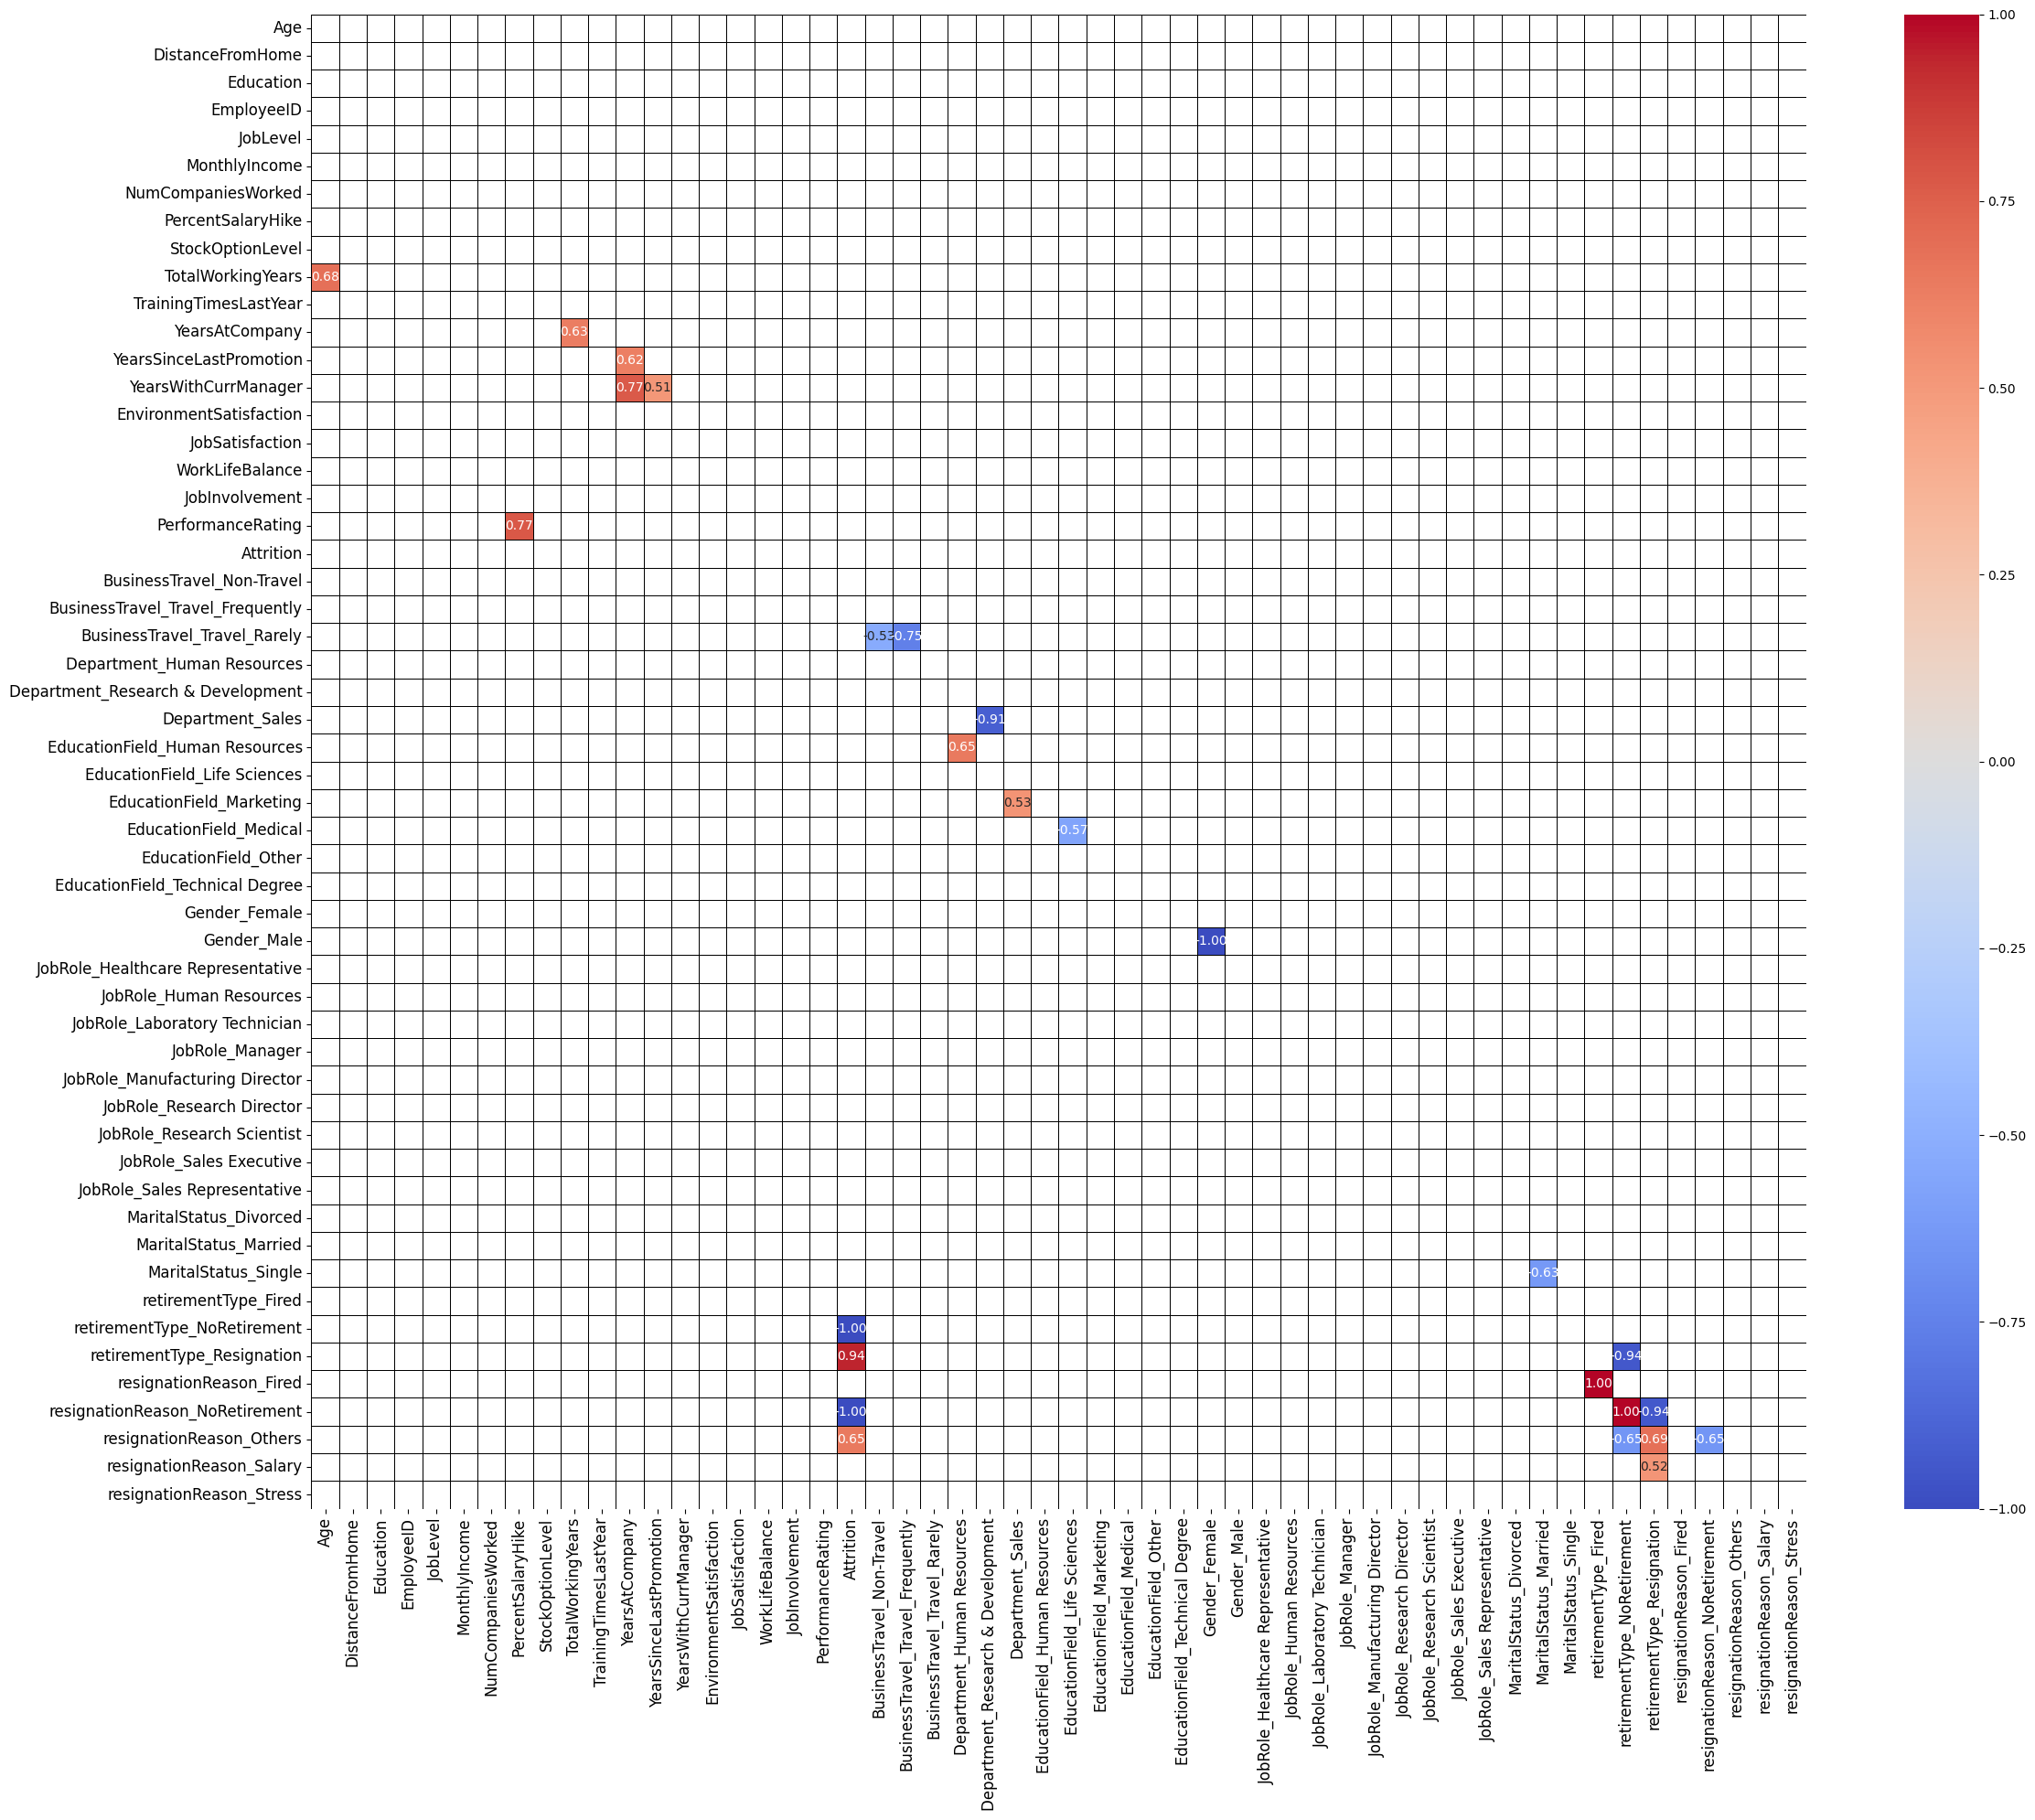

In [24]:
# Calcular la matriz de correlación
correlation_matrix = df_dummies.corr()

# Filtrar las correlaciones que sean superiores a 0.5 o inferiores a -0.5
filtered_corr = correlation_matrix[(correlation_matrix >= 0.5) | (correlation_matrix <= -0.5)]

# Eliminar filas y columnas que no tienen correlaciones significativas
filtered_corr = filtered_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)

# Crear una máscara para la parte superior de la matriz (solo para la parte inferior del mapa de calor)
mask = np.triu(np.ones_like(filtered_corr, dtype=bool))

# Ajustar el tamaño del gráfico
plt.figure(figsize=(25, 20))  # Puedes ajustar el tamaño según sea necesario

# Crear un mapa de calor con la matriz de correlación filtrada
sns.heatmap(filtered_corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0,
            xticklabels=filtered_corr.columns, yticklabels=filtered_corr.columns, square=True, linewidths=0.5, linecolor='black')

# Rotar las etiquetas del eje x para que sean verticales y ajustar la alineación
plt.xticks(rotation=90, ha='center', fontsize=12)
plt.yticks(fontsize=12)

# Ajustar el espaciado para evitar solapamientos
plt.tight_layout()

# Mostrar el gráfico
plt.show()